##HAAR FEATURES

In [ ]:
import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.feature import draw_multiblock_lbp
import pandas as pd
import cv2
import os
from bs4 import BeautifulSoup
from keras.preprocessing.image import img_to_array,load_img
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargo dataset de entrenamiento, cuenta con 200 imagenes de personas con tapabocas como positivos y 200 imagenes de paisajes entre bosques, ciudades, entre otros los cuales se tomarán como negativos.

In [ ]:
datasetPath = '/content/drive/MyDrive/proyecto IA2/notebook_haar/images/'
maskPath = datasetPath + 'p/'
nonMaskPath = datasetPath + 'n/'
images = []
iterador = 0


ruta_base = maskPath
classes = os.listdir(maskPath)
for ruta in (classes[:200]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  resized_img=cv2.resize(img,(25,25))
  images.append(resized_img/255.0)

ruta_base = nonMaskPath
classes = os.listdir(nonMaskPath)
for ruta in (classes[:200]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  resized_img=cv2.resize(img,(25,25))
  images.append(resized_img/255.0)

images = np.array(images)

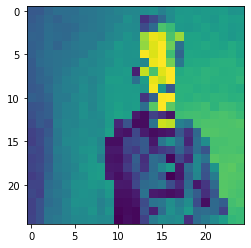

In [ ]:
#ejemplo de la imagenes positivas 
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

Función para extrar las caracteriticas de la imagen, haciendo uso de la librería skimage.image, tomando la imagen desde la fila y la columna cero, y con dimensiones (30,30) por complicaciones con colab y tipo de caracteristicas 'type-2-x' y 'type-2-y' las cuales son útiles para detectar bordes y fueron las que mejor resultado nos dieron.

In [ ]:
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    feature_haar = haar_like_feature(img, 0, 0, img.shape[0], img.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)
    return feature_haar

In [ ]:
#images = lfw_subset()
# To speed up the example, extract the two types of features only
#el mejor tipo de haar feature que nos dio fue de tipo 2
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
# extraigo las mejores caracteristicas de las imagenes

X = delayed(extract_feature_image(img, feature_types) for img in images)
X = np.array(X.compute(scheduler='threads'))
print(X.shape)

# Label images (200 faces and 200 non-faces)
y = np.array([1] * 200 + [0] * 200)

#hacemos la partición del dataset para entrenar nuestro adaBoost y así tener las
#mejores caracteristicas

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

# Extract coordinadas of all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

(400, 101088)


EJEMPLOS CARACTERISTICAS EXTRAIDAS

In [ ]:
X[50]

array([-0.95686275, -1.08627451, -0.95294118, ..., -0.43529412,
       -0.44313725, -0.00784314])

In [ ]:
X[300]

array([-0.76470588, -0.76078431, -0.75294118, ..., -0.06666667,
        0.01568627,  0.08235294])

CLASIFICACIÓN

In [ ]:
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Train a random forest classifier and assess its performance
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

auc_full_features = roc_auc_score(y_test, abc.predict_proba(X_test)[:, 1])
accu = metrics.accuracy_score(y_test, y_pred)
print('accuaracy = ' , accu)


accuaracy =  0.824


GRÁFICA LAS MEJORES NUEVE CARACTERISTICAS DEL DATASET SOBRE UNA PERSONA CON TAPABOCAS

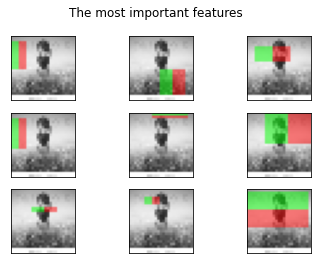

In [ ]:
# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(abc.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 3)
for idx, ax in enumerate(axes.ravel()):
    image = images[199]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

UMBRAL PARA EXTRAER SOLO LAS CARACTERISTICAS DONDE LA IMPORTANCIA SEA MAYOR DE 70%

In [ ]:
abc_feature_importances = np.cumsum(abc.feature_importances_[idx_sorted])
abc_feature_importances /= abc_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(abc_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(abc_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the '
       'AdaBoost.').format(sig_feature_count, sig_feature_percent))

33 features, or 0.0%, account for 70% of branch points in the AdaBoost.


SELECCIÓN DE LAS MEJORES CARACTERISTICAS PARA TRABAJAR CON ESTAS

In [ ]:
# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
print(feature_coord_sel.shape)

(33,)


VALIDO CON EL MISMO DATASET PERO ENTRENO Y CALCULO EL ACCUARACY TOMANDO COMO X LAS CARACTERISTICAS LAS CUALES LAS CALCULO TENIENDO EN CUENTA LAS COORDENADAS ELEGIDAS COMO LAS MEJORES

In [ ]:
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in images)

X = np.array(X.compute(scheduler='threads'))

y = np.array([1] * 200 + [0] * 200)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

In [ ]:
abc.fit(X_train, y_train)

auc_subs_features = roc_auc_score(y_test, abc.predict_proba(X_test)[:, 1])

summary = (('for an AUC of {:.2f}. Computing the restricted '
            'for an AUC of {:.2f}.')
           .format(auc_full_features, auc_subs_features))

print(summary)
plt.show()

for an AUC of 0.90. Computing the restricted for an AUC of 0.88.


####VALIDADO CON EL DATASET FACE MASK DETECTION KAGGLE

In [ ]:
img_folder = '/content/drive/MyDrive/proyecto IA2/prueba_test/images/'
annot_folder = '/content/drive/MyDrive/proyecto IA2/prueba_test/annotations/'
desc = []
for dirname, _, filenames in os.walk(annot_folder):
    for filename in filenames:
        desc.append(os.path.join(dirname, filename))

In [ ]:
img_name,label = [],[]

for d in desc:
    content = []
    n = []

    with open(d, "r") as file:
        content = file.readlines()
    content = "".join(content)
    soup = BeautifulSoup(content,"html.parser")
    file_name = soup.filename.string
    name_tags = soup.find_all("name")
    

    for t in name_tags:
        n.append(t.get_text())
        
    # slecting tag with maximum occurence in an image (If it has multiple tags)
    name = max(set(n), key = n.count)
  
    img_name.append(file_name)
    if (name == 'mask_weared_incorrect' or name == 'with_mask'):
      name = 1
      label.append(name)
    elif (name == 'without_mask'):
      name = 0
      label.append(name)
labels = pd.get_dummies(label)

In [ ]:
data, target = [],[]
img_h, img_w = 25, 25

for i in range(len(img_name)):
    
    name = img_name[i]
    path = img_folder + name
    

    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(img_h,img_w))
    image = img/255.0

    # image = load_img(path, target_size = (img_h, img_w))
    # image = img_to_array(image)
    data.append(image)
    target.append(tuple(labels.iloc[i,:]))

In [ ]:
data = np.array(data)
target = np.array(target)
print("data shapes : ",(data.shape))
print("target shapes : ",(target.shape))

data shapes :  (853, 25, 25)
target shapes :  (853, 2)


In [ ]:
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in data)

X = np.array(X.compute(scheduler='threads'))

y = np.array(label)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99,
#                                                    random_state=0,
#                                                    stratify=y)

0.6658851113716295


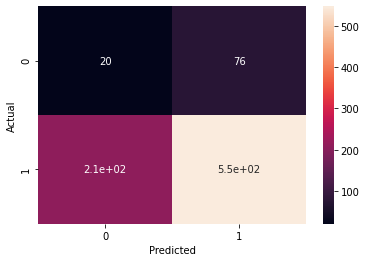

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
results = metrics.accuracy_score(y, abc.predict(X))
print(results)
data = {'y_Actual':    y,
        'y_Predicted': abc.predict(X)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

###MAS EJEMPLOS

In [ ]:
datasetPath = '/content/drive/MyDrive/proyecto IA2/notebook_haar/images/'
maskPath = datasetPath + 'p/'
nonMaskPath = datasetPath + 'n/'
images = []
iterador = 0


ruta_base = maskPath
classes = os.listdir(maskPath)
for ruta in (classes[:300]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  resized_img=cv2.resize(img,(30,30))
  images.append(resized_img/255.0)

ruta_base = nonMaskPath
classes = os.listdir(nonMaskPath)
for ruta in (classes[:300]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  resized_img=cv2.resize(img,(30,30))
  images.append(resized_img/255.0)

images = np.array(images)

In [ ]:
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [ ]:
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='threads'))
time_full_feature_comp = time() - t_start

# Label images (200 faces and 200 non-faces)
y = np.array([1] * 300 + [0] * 300) # ver que es y
# saber que es stratify

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                    random_state=0,
                                                    stratify=y)

# Extract all possible features
#mirar bien haar_like_feature_coord y haar_like_feature
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

[[(4, 11), (16, 20)], [(17, 11), (29, 20)]]
[[(10, 15), (11, 19)], [(10, 20), (11, 24)]]
[[(3, 25), (12, 29)], [(13, 25), (22, 29)]]
[[(14, 2), (17, 2)], [(18, 2), (21, 2)]]
[[(0, 0), (17, 1)], [(0, 2), (17, 3)]]
[[(16, 0), (29, 4)], [(16, 5), (29, 9)]]


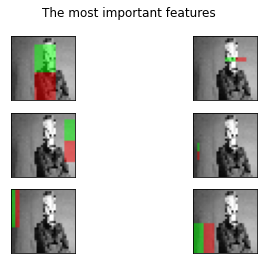

In [ ]:
# Train a random forest classifier and assess its performance
clf = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    print(feature_coord[idx_sorted[idx]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

In [ ]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the '
       'random forest.').format(sig_feature_count, sig_feature_percent))

# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='threads'))
time_subs_feature_comp = time() - t_start

y = np.array([1] * 300 + [0] * 300)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

34 features, or 0.0%, account for 70% of branch points in the random forest.


In [ ]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

summary = (('Computing the full feature set took {:.3f}s, plus {:.3f}s '
            'training, for an AUC of {:.2f}. Computing the restricted '
            'feature set took {:.3f}s, plus {:.3f}s training, '
            'for an AUC of {:.2f}.')
           .format(time_full_feature_comp, time_full_train,
                   auc_full_features, time_subs_feature_comp,
                   time_subs_train, auc_subs_features))

print(summary)
plt.show()

Computing the full feature set took 0.376s, plus 529.129s training, for an AUC of 0.97. Computing the restricted feature set took 0.003s, plus 0.100s training, for an AUC of 0.98.


In [ ]:
data, target = [],[]
img_h, img_w = 30, 30

for i in range(len(img_name)):
    
    name = img_name[i]
    path = img_folder + name
    

    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(img_h,img_w))
    image = img/255.0

    # image = load_img(path, target_size = (img_h, img_w))
    # image = img_to_array(image)
    data.append(image)
    target.append(tuple(labels.iloc[i,:]))

In [ ]:
data = np.array(data)
target = np.array(target)
print("data shapes : ",(data.shape))
print("target shapes : ",(target.shape))

data shapes :  (853, 30, 30)
target shapes :  (853, 2)


In [ ]:
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in data)

X = np.array(X.compute(scheduler='threads'))

y = np.array(label)

In [ ]:
clf.fit(X_train, y_train)

auc_subs_features = roc_auc_score(y, clf.predict_proba(X)[:, 1])

summary = (('for an AUC of {:.2f}. Computing the restricted '
            'for an AUC of {:.2f}.')
           .format(auc_full_features, auc_subs_features))

print(summary)
plt.show()

for an AUC of 0.97. Computing the restricted for an AUC of 0.55.


0.7549824150058617


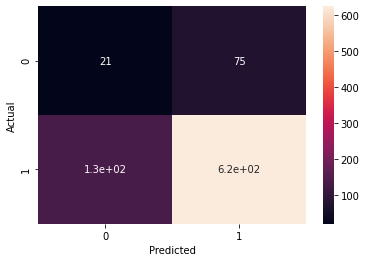

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
results = metrics.accuracy_score(y, clf.predict(X))
print(results)
data = {'y_Actual':    y,
        'y_Predicted': clf.predict(X)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

###NUEVO DATASET

In [ ]:
coordenadas = feature_coord[idx_sorted[:6]]
coordenadas = np.array(coordenadas)

In [ ]:
coordenadas

array([list([[(4, 11), (16, 20)], [(17, 11), (29, 20)]]),
       list([[(10, 15), (11, 19)], [(10, 20), (11, 24)]]),
       list([[(3, 25), (12, 29)], [(13, 25), (22, 29)]]),
       list([[(14, 2), (17, 2)], [(18, 2), (21, 2)]]),
       list([[(0, 0), (17, 1)], [(0, 2), (17, 3)]]),
       list([[(16, 0), (29, 4)], [(16, 5), (29, 9)]])], dtype=object)

In [ ]:
lena = cv2.imread("/content/drive/MyDrive/proyecto IA2/notebook_haar/images/p/with_mask_1118.jpg")
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
lena=cv2.resize(lena,(30,30))


output = np.zeros_like(lena, dtype=np.uint8)
output[:,:,-1] = 0
for i in range(6):
  for j in range(2):
    # this is your box top_x
    tx,ly,bx,ry = coordenadas[i][j][0][0],coordenadas[i][j][1][0],coordenadas[i][j][0][1],coordenadas[i][j][1][1]

    # copy lena to output
    output[tx:bx,ly:ry] = lena[tx:bx,ly:ry]

cv2.addWeighted(lena, 0, output, 1 - .5, 0, output);

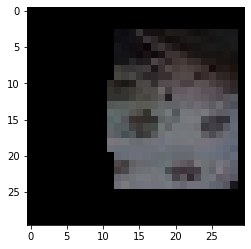

In [ ]:
plt.imshow(output)

In [ ]:
datasetPath = '/content/drive/MyDrive/proyecto IA2/notebook_haar/images/'
maskPath = datasetPath + 'p/'
nonMaskPath = datasetPath + 'n/'
images = []
iterador = 0


ruta_base = maskPath
classes = os.listdir(maskPath)
for ruta in (classes[:300]):
  img = cv2.imread(ruta_base + '/' + ruta)
  lena = cv2.resize(img,(30,30))
  output = np.zeros_like(lena, dtype=np.uint8)
  output[:,:,-1] = 0
  for i in range(6):
    for j in range(2):
      # this is your box top_x
      tx,ly,bx,ry = coordenadas[i][j][0][0],coordenadas[i][j][1][0],coordenadas[i][j][0][1],coordenadas[i][j][1][1]

      # copy lena to output
      output[tx:bx,ly:ry] = lena[tx:bx,ly:ry]

  cv2.addWeighted(lena, 0, output, 1 - .5, 0, output);
  cv2.imwrite('/content/drive/MyDrive/proyecto IA2/HaarCascadeTest/positivas/'+ruta,output)

ruta_base = nonMaskPath
classes = os.listdir(nonMaskPath)
for ruta in (classes[:300]):
  img = cv2.imread(ruta_base + '/' + ruta)
  lena = cv2.resize(img,(30,30))
  output = np.zeros_like(lena, dtype=np.uint8)
  output[:,:,-1] = 0
  for i in range(6):
    for j in range(2):
      # this is your box top_x
      tx,ly,bx,ry = coordenadas[i][j][0][0],coordenadas[i][j][1][0],coordenadas[i][j][0][1],coordenadas[i][j][1][1]

      # copy lena to output
      output[tx:bx,ly:ry] = lena[tx:bx,ly:ry]

  cv2.addWeighted(lena, 0, output, 1 - .5, 0, output);
  cv2.imwrite('/content/drive/MyDrive/proyecto IA2/HaarCascadeTest/negativos/'+ruta,output)


###VALIDACION

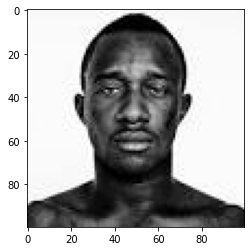

In [ ]:
img = cv2.imread('/content/drive/MyDrive/proyecto IA2/self-built-masked-face-recognition-dataset/without_mask/without_mask_1.jpg')
plt.imshow(img)

In [ ]:
datasetPath = '/content/drive/MyDrive/proyecto IA2/HaarCascadeTest/'
maskPath = datasetPath + 'positivas/'
datasetPath2 = '/content/drive/MyDrive/proyecto IA2/self-built-masked-face-recognition-dataset/'
nonMaskPath = datasetPath2 + 'without_mask'
y_mask = []
x_mask = []
y_no_mask = []
x_no_mask = []
iterador = 0


ruta_base = nonMaskPath
classes = os.listdir(nonMaskPath)
for ruta in (classes[:300]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.resize(img,(30,30))
  x_no_mask.append(img/255.0)
  y_no_mask.append(0)
print(np.shape(y_no_mask))

ruta_base = maskPath
classes = os.listdir(maskPath)
for ruta in (classes):
  img = cv2.imread(ruta_base + '/' + ruta)
  x_mask.append(img/255.0)
  y_mask.append(1)
print(np.shape(y_mask))


x_mask = np.array(x_mask)
y_mask = np.array(y_mask)
x_no_mask = np.array(x_no_mask)
y_no_mask = np.array(y_no_mask)

(300,)
(300,)


In [ ]:
x_no_mask[0].shape

(30, 30, 3)

In [ ]:
x =  np.concatenate((x_no_mask,x_mask))
y = np.concatenate((y_no_mask,y_mask))
print('x',x.shape,'y',y.shape)

x (600, 30, 30, 3) y (600,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
print('y_train:',y_train.shape)
print('y_test:',y_test.shape)

X_train: (450, 30, 30, 3)
X_test: (150, 30, 30, 3)
y_train: (450,)
y_test: (150,)


In [ ]:
import tensorflow as tf
y_test = tf.keras.utils.to_categorical(y_test) #el one hot encoding
y_train = tf.keras.utils.to_categorical(y_train) 

In [ ]:
primer_modelo = tf.keras.models.Sequential()
primer_modelo.add(tf.keras.layers.Conv2D(200, (3, 3), activation='elu', padding='same', input_shape=(X_train.shape[1], X_train.shape[1], 3)))
primer_modelo.add(tf.keras.layers.MaxPooling2D((2, 2)))
primer_modelo.add(tf.keras.layers.Conv2D(100, (3, 3), activation='elu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal', padding='same'))
primer_modelo.add(tf.keras.layers.MaxPooling2D((3, 3)))
primer_modelo.add(tf.keras.layers.MaxPooling2D((2, 2)))
primer_modelo.add(tf.keras.layers.Conv2D(100, (3, 3), activation='elu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal', padding='same'))
primer_modelo.add(tf.keras.layers.MaxPooling2D((2, 2)))
primer_modelo.add(tf.keras.layers.Flatten())
primer_modelo.add(tf.keras.layers.Dropout(0.5))
primer_modelo.add(tf.keras.layers.Dense(50, activation='elu'))
primer_modelo.add(tf.keras.layers.Dropout(0.2))
primer_modelo.add(tf.keras.layers.Dense(2, activation='softmax'))

primer_modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 200)       5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 100)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 100)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 100)         90100     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 100)         0

In [ ]:
opt = tf.keras.optimizers.Adam()
primer_modelo.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/proyecto IA2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


history = primer_modelo.fit(X_train, y_train, epochs=20,verbose=1,validation_split = 0.2,
                    validation_data=(X_test, y_test))

Epoch 1/20
12/12 [==============================] - 3s 37ms/step - loss: 0.4358 - accuracy: 0.7727 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 2/20
12/12 [==============================] - 0s 11ms/step - loss: 0.0306 - accuracy: 0.9916 - val_loss: 6.4128e-04 - val_accuracy: 1.0000
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 4.7967e-05 - val_accuracy: 1.0000
Epoch 4/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0211 - accuracy: 0.9923 - val_loss: 1.5573e-04 - val_accuracy: 1.0000
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0099 - accuracy: 0.9936 - val_loss: 6.0742e-05 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 0s 10ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.0165e-04 - val_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 0s 11ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 5.0573e-05 - val_accura

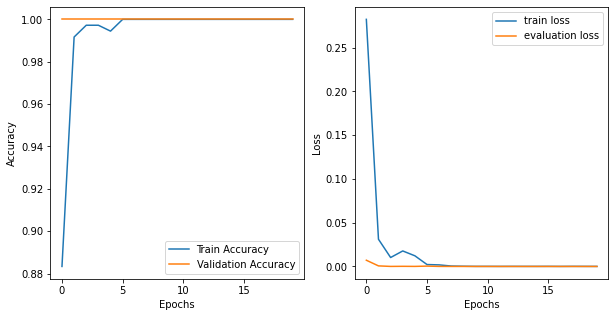

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

validar

In [ ]:
datasetPath = '/content/drive/MyDrive/proyecto IA2/self-built-masked-face-recognition-dataset/'
maskPath = datasetPath + 'with_mask/'
nonMaskPath = datasetPath + 'without_mask/'
y_mask = []
x_mask = []
y_no_mask = []
x_no_mask = []
iterador = 0


ruta_base = nonMaskPath
classes = os.listdir(nonMaskPath)
for ruta in (classes[100:150]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.resize(img,(30,30))
  x_no_mask.append(img/255.0)
  y_no_mask.append(0)
print(np.shape(y_no_mask))

ruta_base = maskPath
classes = os.listdir(maskPath)
for ruta in (classes[:50]):
  img = cv2.imread(ruta_base + '/' + ruta)
  img = cv2.resize(img,(30,30))
  x_mask.append(img/255.0)
  y_mask.append(1)
print(np.shape(y_mask))


x_mask = np.array(x_mask)
y_mask = np.array(y_mask)
x_no_mask = np.array(x_no_mask)
y_no_mask = np.array(y_no_mask)

(50,)
(50,)


In [ ]:
x =  np.concatenate((x_no_mask,x_mask))
y = np.concatenate((y_no_mask,y_mask))
print('x',x.shape,'y',y.shape)

x (100, 30, 30, 3) y (100,)


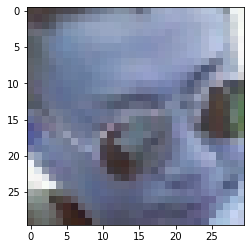

In [ ]:
plt.imshow(x[20])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


PORCENTAJE PREDICCIÓN = 25.0




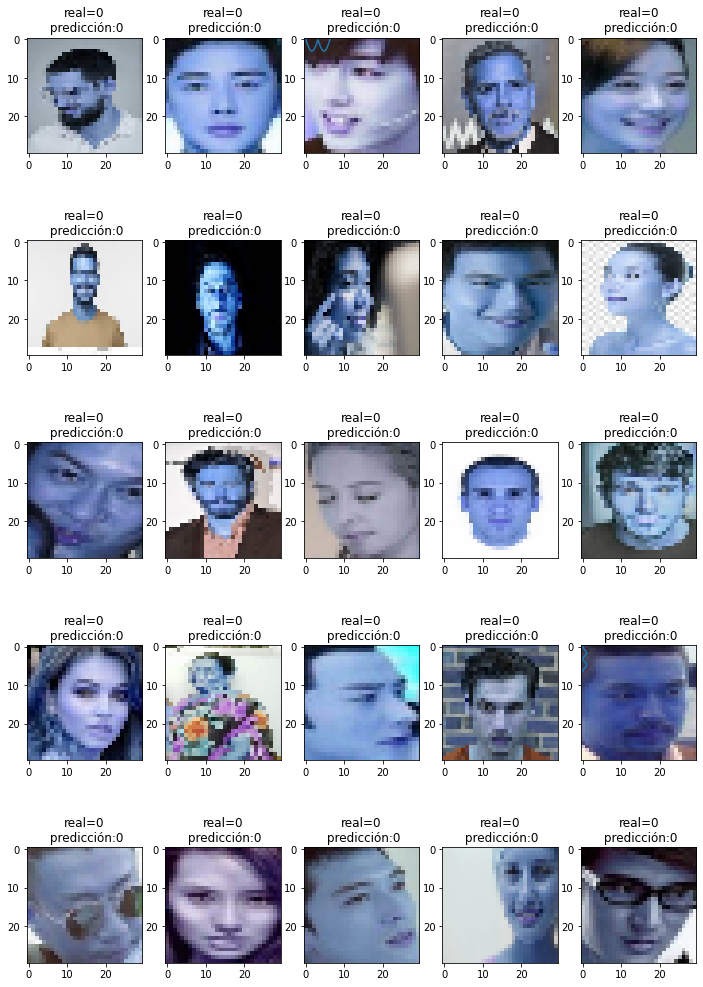

In [ ]:
fig = plt.figure(figsize=(12, 18))
columns = 5
rows = 5

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []
porcentaje = 0
ynew = primer_modelo.predict_classes(x)

for i in range(columns*rows):
    img = x[i] 
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    if(y[i] == ynew[i] ):
      porcentaje += 1
    ax[-1].set_title("real="+str(y[i])+"\n predicción:"+str(ynew[i]))
    plt.imshow(img)

# do extra plots on selected axes/subplots
# note: index starts with 0
ax[2].plot(xs, 3*ys)
ax[19].plot(ys**2, xs)

print('PORCENTAJE PREDICCIÓN = '+ str((porcentaje/100)*100))
print('\n')

plt.show()  # finally, render the plot


0.5


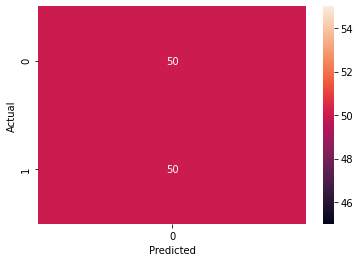

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
results = metrics.accuracy_score(y, ynew)
print(results)
data = {'y_Actual':    y,
        'y_Predicted': ynew
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()